In [1]:
import numpy
import os

In [2]:
%matplotlib inline

In [176]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": False,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
})

In [4]:
from csv import DictReader, reader

In [180]:
import pp_util
import importlib
importlib.reload(pp_util)

<module 'pp_util' from '/home/jsewall/misc/pp/2020/metrics/scripts/pp_util.py'>

In [6]:
qual_colormap = plt.get_cmap("tab10")
plat_order=["OpenMP", "Kokkos", "CUDA", "OpenACC", "OpenCL"]
csv_root="../data/"

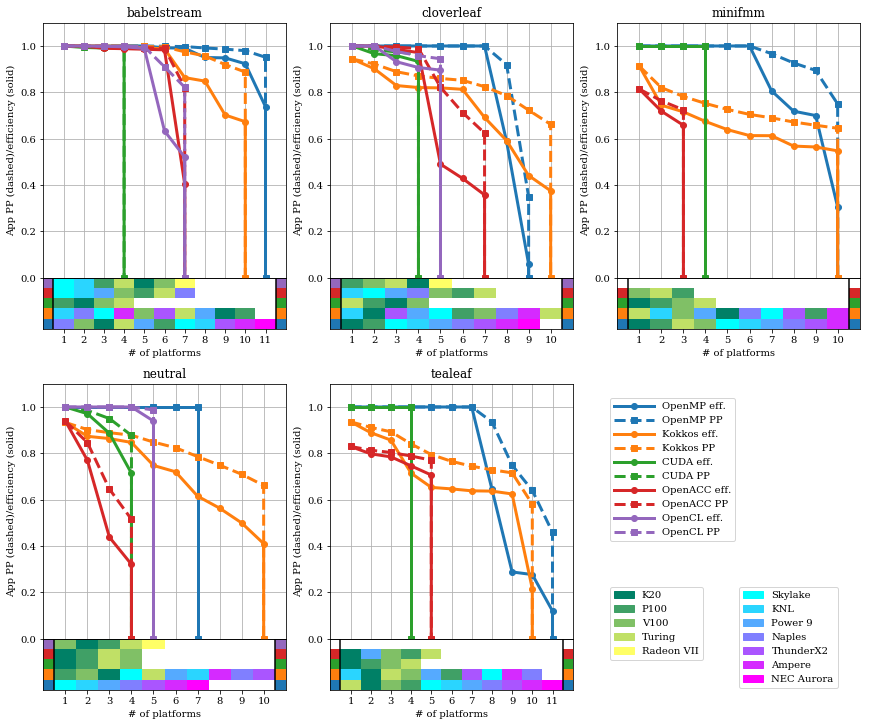

In [201]:
fig = plt.figure(figsize=(12, 10))
plat_colors = {}
gpu_handles = []
cpu_handles = []
handles = {}
gs = fig.add_gridspec(2,3)
for i, appfile in enumerate(["babelstream.csv", "cloverleaf.csv", "minifmm.csv", "neutral.csv", "tealeaf.csv"]):
    col = i-3*(i//3)
    row = i//3 
    index = [row, col]
    subgrid=gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=gs[row,col],hspace=0, height_ratios=[5,1])

    ax2 = fig.add_subplot(subgrid[1,:])
    ax = fig.add_subplot(subgrid[0,:],sharex=ax2)
    
    throughput=(appfile == "babelstream.csv")
    integrate=False
    appname=None
    pp_util.load_app_perfs(os.path.join(csv_root, appfile), throughput=throughput)
    
    if plat_colors == {}:
        gpus=[]
        cpus=[]
        for name,plat in pp_util.platforms.items():
            if 'GPU' in plat.types:
                gpus.append(name)
            if 'CPU' in plat.types:
                cpus.append(name)
        gpu_cmap = plt.get_cmap("summer")
        cpu_cmap = plt.get_cmap("cool")
        #cpu_cmap = plt.get_cmap("summer")
        
        for i, p in enumerate(gpus):
            plat_colors[p] = gpu_cmap(float(i)/(len(gpus)-1))
            gpu_handles.append(mpatches.Patch(color=plat_colors[p], label=p))
        for i, p in enumerate(cpus):
            plat_colors[p] = cpu_cmap(float(i)/(len(cpus)-1))
            cpu_handles.append(mpatches.Patch(color=plat_colors[p], label=p))
        #for i, p in enumerate(cpus + gpus):
            #plat_colors[p] = cpu_cmap(i)
        #    plat_colors[p] = cpu_cmap(float(i)/len(gpus+cpus))
            
    min_plat = None
    max_plat = None
    appinfo = {}  
    for idx, name in enumerate(plat_order):
        if name not in pp_util.apps:
            continue
        data  = pp_util.apps[name]

        cascade = pp_util.pp_cdf(data, list(pp_util.platforms.keys()), throughput)
        
        effs, pps, plats = zip(*cascade)
        
        ppl = list(enumerate(reversed(pps),1))
        ppl =  ppl + [(ppl[-1][0], 0.0)]
        data_pp = numpy.asarray(ppl)
        effl = list(enumerate(reversed(effs),1))
        effl =  effl + [(effl[-1][0], 0.0)]
        data_eff = numpy.asarray(effl)
    
        center = data_pp[:,0]

        lo = center-0.5
        hi = center+0.5
        if min_plat == None or center[0] < min_plat:
            min_plat = center[0]
        if max_plat == None or center[-1] > max_plat:
            max_plat = center[-1]

        appinfo[name] = (data, data_pp, data_eff, plats, center)

    for name, (data, data_pp, data_eff, plats, center) in appinfo.items():
        eff_name=f"{name} eff."
        pp_name=f"{name} PP"

        c = qual_colormap(plat_order.index(name))
        if integrate:
            tmp = numpy.zeros(data_pp.shape[0])
            tmp[0] = data_pp[0,1]
            for i in range(1, data_pp.shape[0]-1):
                tmp[i] = scipy.integrate.trapz(data_pp[:i+1,1]) + tmp[0]
            data_pp[:,1] = tmp
            data_pp[-1,1] = data_pp[-2,1]
            data_pp[-1,0] = max_plat

            tmp[0] = data_eff[0,1]
            for i in range(1, data_eff.shape[0]-1):
                tmp[i] = scipy.integrate.trapz(data_eff[:i+1,1]) + tmp[0]
            data_eff[:,1] = tmp
            data_eff[-1,1] = data_eff[-2,1]
            data_eff[-1,0] = max_plat
            mycenter = center[:]
            mycenter[data_pp.shape[0]-1] = max_plat

            pp_h = ax.plot(mycenter,data_pp[:,1], label=pp_name, color=c, lw=3, marker="s", ls='dashed')[0]
            eff_h = ax.plot(mycenter,data_eff[:,1], label=eff_name, color=c, lw=3)[0]
        else:
            pp_h = ax.plot(center,data_pp[:,1], label=pp_name, color=c, lw=3, marker="s", ls='dashed')[0]
            eff_h = ax.plot(center,data_eff[:,1], label=eff_name, color=c, marker="o", lw=3)[0]
        

        idx = plat_order.index(name)
        
        colors = [plat_colors[p.platform] for p in plats]
        fac=0.25
        ax2.bar(center[:-1], height=fac, width=1.0,bottom=idx*fac,color=colors,edgecolor=c, linewidth=0, alpha=1.0)
    
    
        ax2.bar([0.0, max_plat+1.0], height=fac, width=1.0,bottom=idx*fac,color=c)
    
    
        if eff_name not in handles:
            handles[eff_name] = eff_h
        if pp_name not in handles:
            handles[pp_name] = pp_h
            
    if appname == None:
        appname = os.path.splitext(os.path.basename(appfile))[0]
    if integrate:
        ax.set_title(f"Cumulative {appname} pp/efficiency over # of platforms")
        ax.set_ylabel("Cumulative App PP (dashed)/efficiency (solid)")
    else:
        ax.set_title(f"{appname}")
        ax.set_ylabel("App PP (dashed)/efficiency (solid)")
    ax2.set_xlabel("# of platforms")
    ax2.set_xlim([0,max_plat+1])
    ax2.set_ylim([0,len(plat_order)*fac])
    if not integrate:
        ax.set_ylim([0,1.1])
    else:
        ax.set_ylim([0,max_plat+1])
    ax2.set_xticks(numpy.arange(min_plat, max_plat+1))
    ax2.set_yticks([])
    ax.label_outer()
    ax.xaxis.set_ticks_position('none')
    ax2.axvline(min_plat-0.5,color="black")
    ax2.axvline(max_plat+0.5,color="black")
    ax.grid(True)

handle_names, handle_lists = zip(*handles.items())
fig.legend(handle_lists, handle_names, loc='lower left', bbox_to_anchor=(0.70,0.25),handlelength=4.0)
fig.legend(handles=gpu_handles, loc='upper left', bbox_to_anchor=(0.7,0.20),handlelength=2.0)
fig.legend(handles=cpu_handles, loc='upper left', bbox_to_anchor=(0.85,0.20),handlelength=2.0)
plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
    
plt.savefig(f"../../images/app_platforms_cascade.pdf", bbox_inches="tight")

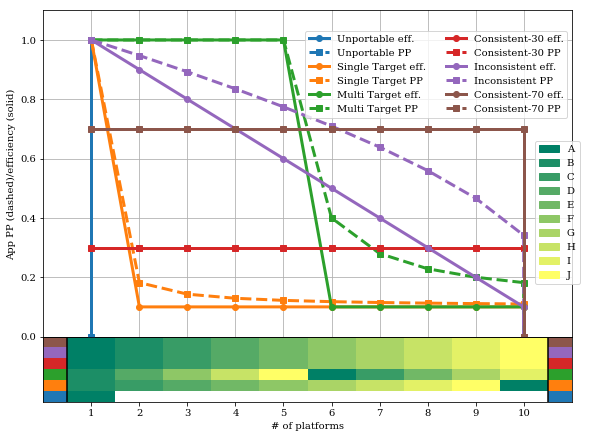

In [200]:
fig = plt.figure(figsize=(8, 6))
plat_colors = {}
plat_handles = []
synth_plats=[chr(x) for x in range(65, 75)]
plat_cmap = plt.get_cmap("summer")
for i, p in enumerate(synth_plats):
    plat_colors[p] = plat_cmap(float(i)/(len(synth_plats)-1))
    plat_handles.append(mpatches.Patch(color=plat_colors[p], label=p))

handles = {}
gs = fig.add_gridspec(1,1)
for i, appfile in enumerate(["metrics_data_synthetic.csv"]):
    index = [0, 0]
    subgrid=gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=gs[index[0],index[1]],hspace=0, height_ratios=[5,1])

    ax2 = fig.add_subplot(subgrid[1,:])
    ax = fig.add_subplot(subgrid[0,:],sharex=ax2)
    
    
    app_eff = pp_util.read_effs(os.path.join(csv_root, appfile))
    integrate=False
    appname=None
    
    min_plat = None
    max_plat = None
    appinfo = {}  
    for i, (name, in_effs) in enumerate(app_eff):
        cascade = pp_util.pp_cdf_raw_effs(in_effs)

        effs, pps, plats = zip(*cascade)
                
        ppl = list(enumerate(reversed(pps),1))
        ppl =  ppl + [(ppl[-1][0], 0.0)]
        data_pp = numpy.asarray(ppl)
        effl = list(enumerate(reversed(effs),1))
        effl =  effl + [(effl[-1][0], 0.0)]
        data_eff = numpy.asarray(effl)
    
        center = data_pp[:,0]

        lo = center-0.5
        hi = center+0.5
        if min_plat == None or center[0] < min_plat:
            min_plat = center[0]
        if max_plat == None or center[-1] > max_plat:
            max_plat = center[-1]

        appinfo[name] = (data, data_pp, data_eff, plats, center, i)

    for name, (data, data_pp, data_eff, plats, center, i) in appinfo.items():
        eff_name=f"{name} eff."
        pp_name=f"{name} PP"

        c = qual_colormap(i)
        if integrate:
            tmp = numpy.zeros(data_pp.shape[0])
            tmp[0] = data_pp[0,1]
            for i in range(1, data_pp.shape[0]-1):
                tmp[i] = scipy.integrate.trapz(data_pp[:i+1,1]) + tmp[0]
            data_pp[:,1] = tmp
            data_pp[-1,1] = data_pp[-2,1]
            data_pp[-1,0] = max_plat

            tmp[0] = data_eff[0,1]
            for i in range(1, data_eff.shape[0]-1):
                tmp[i] = scipy.integrate.trapz(data_eff[:i+1,1]) + tmp[0]
            data_eff[:,1] = tmp
            data_eff[-1,1] = data_eff[-2,1]
            data_eff[-1,0] = max_plat
            mycenter = center[:]
            mycenter[data_pp.shape[0]-1] = max_plat

            pp_h = ax.plot(mycenter,data_pp[:,1], label=pp_name, color=c, lw=3, marker="s", ls='dashed')[0]
            eff_h = ax.plot(mycenter,data_eff[:,1], label=eff_name, color=c, lw=3)[0]
        else:
            pp_h = ax.plot(center,data_pp[:,1], label=pp_name, color=c, lw=3, marker="s", ls='dashed')[0]
            eff_h = ax.plot(center,data_eff[:,1], label=eff_name, color=c, marker="o", lw=3)[0]
        
        colors = [plat_colors[p] for p in plats]
        fac=0.25
        ax2.bar(center[:-1], height=fac, width=1.0,bottom=i*fac,color=colors,edgecolor=c, linewidth=0, alpha=1.0)
       
        ax2.bar([0.0, max_plat+1.0], height=fac, width=1.0,bottom=i*fac,color=c)
    
    
        if eff_name not in handles:
            handles[eff_name] = eff_h
        if pp_name not in handles:
            handles[pp_name] = pp_h
            
    if appname == None:
        appname = os.path.splitext(os.path.basename(appfile))[0]
    if integrate:
     #   ax.set_title(f"Cumulative {appname} pp/efficiency over # of platforms")
        ax.set_ylabel("Cumulative App PP (dashed)/efficiency (solid)")
    else:
    #    ax.set_title(f"{appname}")
        ax.set_ylabel("App PP (dashed)/efficiency (solid)")
    ax2.set_xlabel("# of platforms")
    ax2.set_xlim([0,max_plat+1])
    ax2.set_ylim([0,len(appinfo)*fac])
    if not integrate:
        ax.set_ylim([0,1.1])
    else:
        ax.set_ylim([0,max_plat+1])
    ax2.set_xticks(numpy.arange(min_plat, max_plat+1))
    ax2.set_yticks([])
    ax.label_outer()
    ax.xaxis.set_ticks_position('none')
    ax2.axvline(min_plat-0.5,color="black")
    ax2.axvline(max_plat+0.5,color="black")
    ax.grid(True)

handle_names, handle_lists = zip(*handles.items())
fig.legend(handle_lists, handle_names, loc='lower left', bbox_to_anchor=(0.52,0.73),ncol=2, handlelength=2.0)
fig.legend(handles=plat_handles, loc='upper left', bbox_to_anchor=(0.92,0.70),handlelength=2.0)
plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
    
plt.savefig(f"../../images/synthetic_cascade.pdf", bbox_inches="tight")

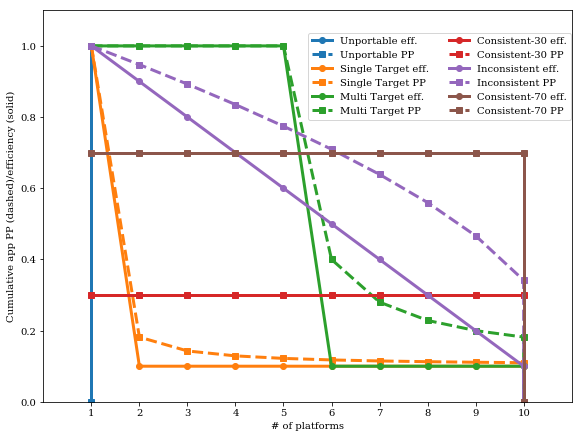

In [28]:
fig = plt.figure(figsize=(8, 6))
handles = {}
for i, appfile in enumerate(["metrics_data_synthetic.csv"]):
    ax = fig.add_subplot(1,1,i+1)
    app_eff = pp_util.read_effs(os.path.join(csv_root, appfile))
    integrate=False
    appname=None
    min_plat = None
    max_plat = None
    appinfo = {}  
    for i, (name, in_effs) in enumerate(app_eff):
        pps, effs = pp_util.pp_cdf_raw_effs(in_effs)

        ppl = list(reversed(pps))
        ppl =  ppl + [(ppl[-1][0], 0.0)]
        data_pp = numpy.asarray(ppl)
        effl = list(reversed(effs))
        effl =  effl + [(effl[-1][0], 0.0)]
        data_eff = numpy.asarray(effl)

        center = data_pp[:,0]

        lo = center-0.5
        hi = center+0.5
        if min_plat == None or center[0] < min_plat:
            min_plat = center[0]
        if max_plat == None or center[-1] > max_plat:
            max_plat = center[-1]

        appinfo[name] = (data, data_pp, data_eff, center, i)
        
    for name, (data, data_pp, data_eff, center, index) in appinfo.items():
        eff_name=f"{name} eff."
        pp_name=f"{name} PP"
        c = qual_colormap(index)
        if integrate:
            tmp = numpy.zeros(data_pp.shape[0])
            tmp[0] = data_pp[0,1]
            for i in range(1, data_pp.shape[0]-1):
                tmp[i] = scipy.integrate.trapz(data_pp[:i+1,1]) + tmp[0]
            data_pp[:,1] = tmp
            data_pp[-1,1] = data_pp[-2,1]
            data_pp[-1,0] = max_plat

            tmp[0] = data_eff[0,1]
            for i in range(1, data_eff.shape[0]-1):
                tmp[i] = scipy.integrate.trapz(data_eff[:i+1,1]) + tmp[0]
            data_eff[:,1] = tmp
            data_eff[-1,1] = data_eff[-2,1]
            data_eff[-1,0] = max_plat
            mycenter = center[:]
            mycenter[data_pp.shape[0]-1] = max_plat

            pp_h = ax.plot(mycenter,data_pp[:,1], label=pp_name, color=c, lw=3, marker="s", ls='dashed')[0]
            eff_h = ax.plot(mycenter,data_eff[:,1], label=eff_name, color=c, lw=3, marker="o")[0]
        else:
            pp_h = ax.plot(center,data_pp[:,1], label=pp_name, color=c, lw=3, marker="s", ls='dashed')[0]
            eff_h = ax.plot(center,data_eff[:,1], label=eff_name, color=c, lw=3, marker="o")[0]
              
        if eff_name not in handles:
            handles[eff_name] = eff_h
        if pp_name not in handles:
            handles[pp_name] = pp_h
            
    if appname == None:
        appname = os.path.splitext(os.path.basename(appfile))[0]
        #ax.set_title(f"Cumulative {} pp/efficiency over # of platforms")
        ax.set_ylabel("Cumulative app PP (dashed)/efficiency (solid)")
    else:
        #ax.set_title(f"{appname}")
        ax.set_ylabel("App PP (dashed)/efficiency (solid)")
    ax.set_xlabel("# of platforms")
    ax.set_xlim([0,max_plat+1])
    if not integrate:
        ax.set_ylim([0,1.1])
    else:
        ax.set_ylim([0,max_plat+1])
    ax.set_xticks(numpy.arange(min_plat, max_plat+1))
handles_names, handles_items = zip(*handles.items())
fig.legend(handles_items, handles_names, loc='upper right',bbox_to_anchor=(1.0, 0.95), handlelength=2.0, ncol=2)
plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
    
plt.savefig(f"../../images/synthetic_cascade.pdf", bbox_inches="tight")